![](img/330-banner.png)

# Lecture 21: Ethics

UBC 2023 Summer

Instructor: Mehrdad Oveisi

## Imports

In [1]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

<br><br>

## ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithms. However, human beings are inherently biased and AI/ML systems, if not carefully evaluated, can even further ***amplify* the existing inequities** and systemic bias in our society.  

- How do we make sure our AI/ML systems are **fair**?
- Which metrics can we use to **quantify 'fairness'** in AI/ML systems?

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [2]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

In [4]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K


In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num", "fnlwgt"]
target = "income"

In [7]:
train_df["education"].unique()

array(['7th-8th', 'Assoc-voc', 'HS-grad', 'Bachelors', 'Some-college',
       '10th', '11th', 'Prof-school', '12th', '5th-6th', 'Masters',
       'Assoc-acdm', '9th', 'Doctorate', '1st-4th', 'Preschool'],
      dtype=object)

In [8]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [9]:
assert set(education_levels) == set(train_df["education"])

In [10]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [11]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [12]:
pd.DataFrame(dict(
    count = y_train.value_counts(),
    ratio = y_train.value_counts(normalize=True)))

,count,ratio
income,,
<=50K,14841,0.759674
>50K,4695,0.240326


In [13]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000)
)

In [14]:
pipe_lr.fit(X_train, y_train);

In [15]:
kw_cm = dict(normalize="true", cmap=plt.cm.Blues) # key-word arguments for all confusion matrices
kw_cm

{'normalize': 'true',
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x7ff5393cfe80>}

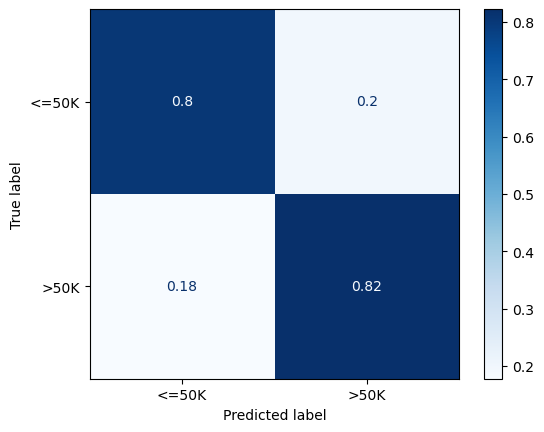

In [16]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, **kw_cm);

<br><br><br><br>

Let's examine confusion matrix separately for the two genders we have in the data. 

**Get predictions for `y_female` and `y_male` with `pipe_lr`**

In [17]:
pipe_lr[0].named_transformers_['pipeline-2']['onehotencoder'].get_feature_names_out(['sex'])

array(['sex_Male'], dtype=object)

In [18]:
X_test.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
14160,29,Private,280618,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
27048,19,Private,439779,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States
28868,28,Private,204734,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States


In [19]:
X_female = X_test.query("sex=='Female'")
X_male = X_test.query("sex=='Male'")

y_female = y_test[X_female.index]
y_male = y_test[X_male.index]

In [20]:
female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

<br><br>

Let's examine the accuracy and confusion matrix for both classes.

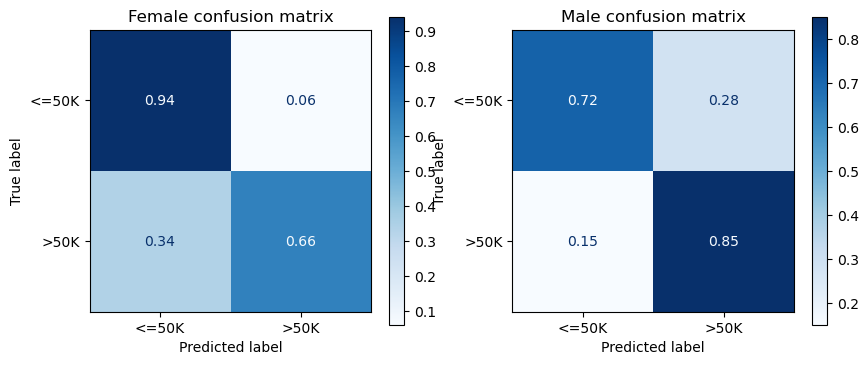

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title('Female confusion matrix')
ax[1].set_title('Male confusion matrix')
ConfusionMatrixDisplay.from_predictions(y_female, female_preds, ax = ax[0], **kw_cm);
ConfusionMatrixDisplay.from_predictions(y_male, male_preds, ax = ax[1], **kw_cm);

In [22]:
from sklearn.metrics import confusion_matrix

f_TN, f_FP, f_FN, f_TP = confusion_matrix(y_female, female_preds).ravel()
m_TN, m_FP, m_FN, m_TP = confusion_matrix(y_male, male_preds).ravel()

<br><br>

What's the **accuracy** of this model? 

In [23]:
data = {"female": {}, "male": {}}

In [24]:
accuracy_female = accuracy_score(y_female, female_preds)
accuracy_male = accuracy_score(y_male, male_preds)

data["female"]['accuracy'] = accuracy_female
data["male"]['accuracy'] = accuracy_male

print(f"Accuracy female: {accuracy_female:.3f}")
print(f"Accuracy male: {accuracy_male:.3f}")

Accuracy female: 0.910
Accuracy male: 0.757


<br>

In [25]:
pd.DataFrame({
    "both": y_test.value_counts(normalize=True),
    "female": y_female.value_counts(normalize=True),
    "male": y_male.value_counts(normalize=True)
})

,both,female,male
income,,,
<=50K,0.758464,0.892675,0.691999
>50K,0.241536,0.107325,0.308001


There is more class imbalance for female! 

<br><br>

**As an example**, let's assume that a company is using **this classifier for loan approval** with a simple rule that:
- if the income is >50K, approve the loan, else reject the loan.

<br><br>

**Statistical parity** suggests that the proportion of each segment of a protected class (e.g. sex) should receive the positive outcome at equal rates. For example, the proportion of loans approved for female should be equal to male.

<br><br>

Calculate the **precision** for male and female.

In [26]:
precision_female = precision_score(y_female, female_preds, pos_label=">50K")
precision_male = precision_score(y_male, male_preds, pos_label=">50K")

data["female"]['precision'] = precision_female
data["male"]['precision'] = precision_male

print("Precision female: {:.5f}".format(precision_female))
print("Precision male: {:.5f}".format(precision_male))

Precision female: 0.57063
Precision male: 0.57057


<br>

In [27]:
pd.DataFrame({
    'count': [len(y_female), len(y_male)],
    'positive outcome': [f_TP + f_FP, m_TP + m_FP],
    'proportion': [(f_TP + f_FP) / len(y_female), (m_TP + m_FP) / len(y_male)],
}, index=['female', 'male'])

,count,positive outcome,proportion
female,4314,538,0.12471
male,8711,3996,0.45873


<br>
Based on your results, do you think this income classifier is fair?

<br><br>

**Equal opportunity** suggests that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. For example, if a man and a woman have both a certain level of income, we want them to have the same chance of getting the loan. In other words, the true positive rate (TPR or recall) of both groups should be equal.

In [28]:
recall_female = recall_score(y_female, female_preds, pos_label=">50K")
recall_male = recall_score(y_male, male_preds, pos_label=">50K")

data["female"]['recall'] = recall_female
data["male"]['recall'] = recall_male

print("Recall female: {:.3f}".format(recall_female))
print("Recall male: {:.3f}".format(recall_male))

Recall female: 0.663
Recall male: 0.850


<br><br>

There is usually a trade-off between rationality (adopting effective means to achieve your desired outcome) and bias (in system). The desired outcome of banks, for example, is to maximize their profit. So in many circumstances, they not only care about approving as many qualified applications as possible (true positive), but also to avoid approving unqualified applications (false positive) because default loan could have detrimental effects for them. 

Let's examine false positive rate (FPR) of both groups.

In [29]:
fpr_female = f_FP / (f_FP + f_TN)
fpr_male = m_FP / (m_FP + m_TN)

data["female"]['FPR'] = fpr_female
data["male"]['FPR'] = fpr_male

print("FPR female: {:.3f}".format(fpr_female))
print("FPR male: {:.3f}".format(fpr_male))

FPR female: 0.060
FPR male: 0.285


<br>

In [30]:
pd.DataFrame(data).T

,accuracy,precision,recall,FPR
female,0.910292,0.570632,0.663067,0.059984
male,0.756744,0.570571,0.849795,0.284672


<br><br><br><br>

### ❓❓ Questions for group discussion

Let's assume that a company is using this classifier for loan approval with a simple rule that if the income is >=50K, approve the loan, else reject the loan. 

Discuss the questions below with your neighbour(s) and write the main points from your discussion in this Google Doc for [section 911](https://docs.google.com/document/d/1VONJX9w9SIpOrW2SCn8X8r76-2rMYWDxQd6JLBPEUsg) or [section 912](https://docs.google.com/document/d/1It0OLpD6gGAWYfGVQruc_45aw9ZwZDQ8JjaQ2vxNwGI/edit?usp=sharing).

1. Which group has a higher accuracy?
2. Which group has a higher precision for class >50K? What about recall for class >50K?
3. Will both groups have more or less the same proportion of people with approved loans? 
4. If a male and a female have both a certain level of income, will they have the same chance of getting the loan?
5. Banks want to avoid approving unqualified applications (false positives) because default loan could have detrimental effects for them. Compare the false positive rates for the two groups.    
6. Overall, do you think this income classifier will fairly treat both groups? What will be the consequences of using this classifier in loan approval application? 


<br><br>

**Time permitting**
1. Do you think the effect will still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 
2. Are there any other groups in this dataset worth examining for biases? 